In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


# 라이브러리

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 파이썬 시계열 기본 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [4]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/iM_alphaco/시계열 강의안(통계, ML, DL)/data/'

df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

# 시계열의 가장 기본적인 포멧

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [6]:
df.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


# 데이터 시각화

In [8]:
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961


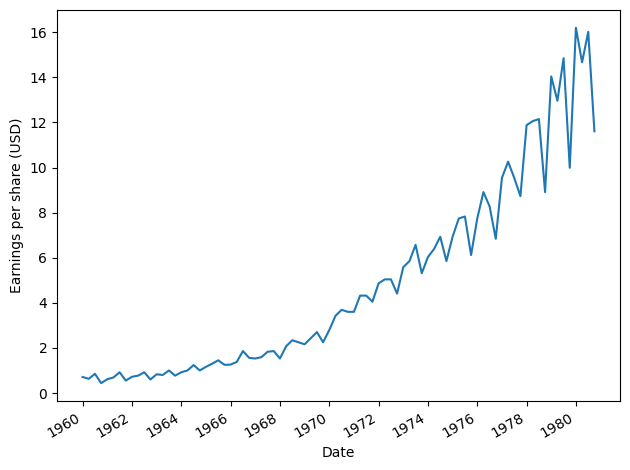

In [20]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 시계열 분해 및 시각화
- 메서드 공식 DOCS에서 참고하기

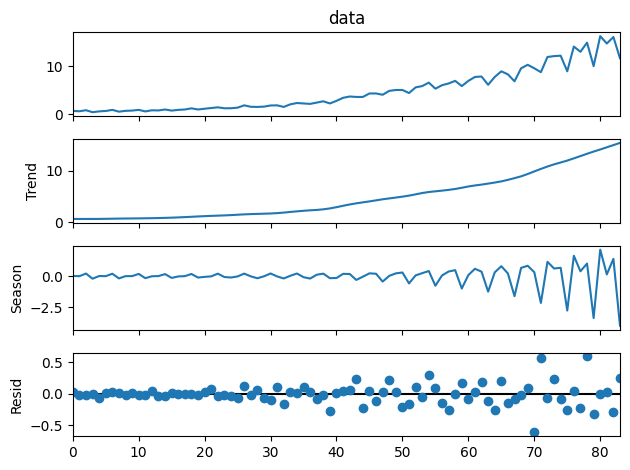

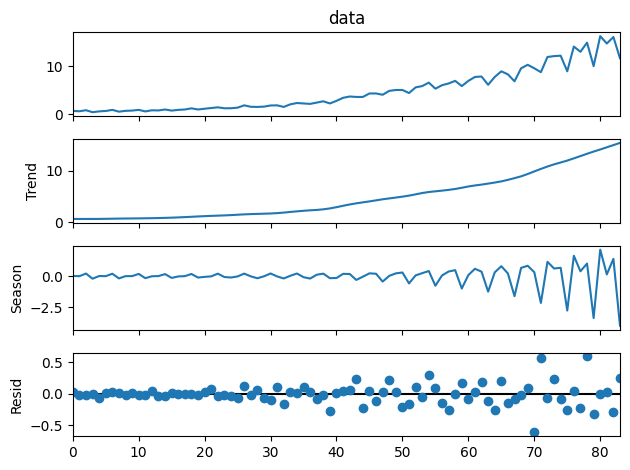

In [25]:
res = STL(df.data, period = 4).fit()
res.plot()

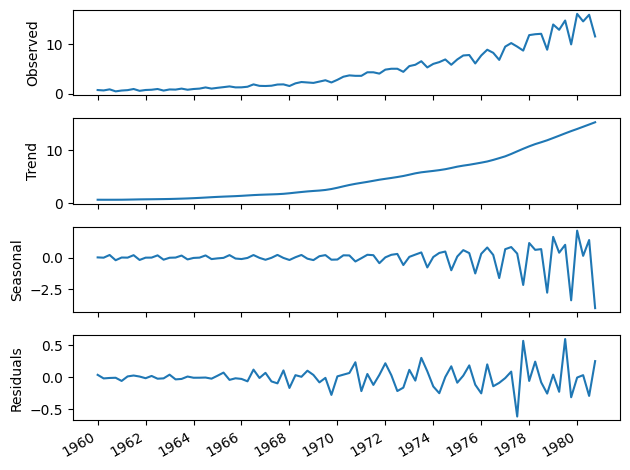

In [26]:
advanced_decomposition = STL(df.data, period=4).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 데이터 복원
- 원래상태로 복구

In [29]:
df = df.drop('year', axis = 1)
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


## 베이스라인 모델 설계
- ML과는 다른 모델 설계
- 훈련데이터 : 1960년 ~ 1979년
- 예측데이터 : 1980년

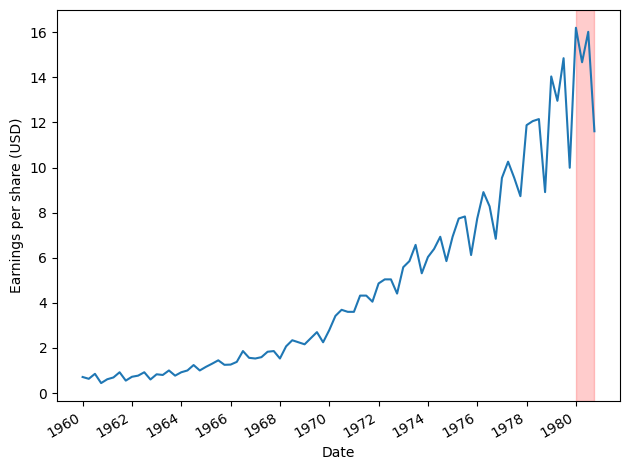

In [33]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='red', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 평가 지표 만들기
- MAPE함수 만들기

In [34]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 데이터 셋 분리
- 분기 기준이므로 마지막 4분기만 테스트 데이터로 잘라내면 된다.

In [35]:
train = df[:-4]
test = df[-4:]

In [36]:
test

,date,data
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [37]:
train.head(4)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44


## 모델 학습

- 되게 단순해보이지만 이게 베이스라인 모델이다!

In [38]:
historical_mean = np.mean(train['data'])
historical_mean

4.308499987499999

In [39]:
test.loc[:, 'preds'] = historical_mean
test

<ipython-input-39-3376cca569a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'preds'] = historical_mean


,date,data,preds
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


## 모델 평가

In [40]:
mape(test['data'], test['preds'])

70.00752579965119

In [41]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test['data'], test['preds']) * 100

70.00752579965119

## 모델 평가 - 두 번째 모델

In [47]:
train[-4:]

,date,data
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85
79,1979-10-01,9.99


In [43]:
second_mean = np.mean(train['data'][-4:])
second_mean

12.96

In [48]:
test.loc[:, '1979preds'] = second_mean
mean_absolute_percentage_error(test['data'], test['1979preds']) * 100

<ipython-input-48-b36047ec8a64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, '1979preds'] = second_mean


15.5963680725103